<a href="https://colab.research.google.com/github/sssmin2/jinung_sw/blob/main/01_AE%EC%8B%A4%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### 라이브러리

In [14]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import itertools
%matplotlib inline

#### 모델 정의

In [15]:
batch_size = 100

In [16]:
class Encoder(nn.Module):
  def __init__(self):
    super(Encoder,self).__init__()
    self.layer1 = nn.Sequential(
    nn.Conv2d(1,16,3,padding=1), nn.ReLU(),
    nn.BatchNorm2d(16),
    nn.Conv2d(16,32,3,padding=1), # 32 x 28 x 28
    nn.ReLU(),
    nn.BatchNorm2d(32),
    nn.Conv2d(32,64,3,padding=1), # 64 x 28 x 28
    nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.MaxPool2d(2,2)
    # 16 x 28 x 28
    # 64 x 14 x 14
    )
    self.layer2 = nn.Sequential(
    nn.Conv2d(64,128,3,padding=1), # 128 x 14 x 14
    nn.ReLU(),
    nn.BatchNorm2d(128),
    nn.MaxPool2d(2,2),
    nn.Conv2d(128,256,3,padding=1), # 256 x 7 x 7
    nn.ReLU()
    )
  def forward(self,x):
    out = self.layer1(x)
    out = self.layer2(out)
    out = out.view(batch_size,-1)
    return out

In [17]:
class Decoder(nn.Module):
  def __init__(self):
    super(Decoder,self).__init__()
    self.layer1 = nn.Sequential(
    nn.ConvTranspose2d(256,128,3,2,1,1), # 128 x 14 x 14
    nn.ReLU(),
    nn.BatchNorm2d(128),
    nn.ConvTranspose2d(128,64,3,1,1), # 64 x 14 x 14
    nn.ReLU(),
    nn.BatchNorm2d(64)
    )
    self.layer2 = nn.Sequential(
    nn.ConvTranspose2d(64,16,3,1,1), # 16 x 14 x 14
    nn.ReLU(),
    nn.BatchNorm2d(16),
    nn.ConvTranspose2d(16,1,3,2,1,1), # 1 x 28 x 28
    nn.ReLU()
    )
  def forward(self,x):
    out = x.view(batch_size,256,7,7)
    out = self.layer1(out)
    out = self.layer2(out)
    return out

#### 데이터 로딩 & 데이터 로더

In [18]:
mnist_train = dset.MNIST("./data/MNIST", train=True,
transform=transforms.ToTensor(), target_transform=None, download=True)

mnist_test = dset.MNIST("./data/MNIST", train=False,
transform=transforms.ToTensor(), target_transform=None, download=True)

In [19]:
train_loader = torch.utils.data.DataLoader(mnist_train,
batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)

test_loader = torch.utils.data.DataLoader(mnist_test,
batch_size=batch_size, shuffle=False, num_workers=2, drop_last=True)

#### 초기 설정

In [20]:
num_epoch = 10
learning_rate = 0.0002
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder = Encoder().to(device)
decoder = Decoder().to(device)
parameters = itertools.chain(encoder.parameters(), decoder.parameters())
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(parameters, lr=learning_rate)

#### 훈련 전 test

In [21]:
for i in range(1):
  for j,[image, label] in enumerate(test_loader):
    image = image.to(device)
    z = encoder(image)
    output = decoder(z)
    loss = loss_func(output,image)
# if j % 10 == 0:
# print(loss)
  print("loss is", loss.cpu().item())

loss is 0.5457990765571594


#### Test 결과 출력

torch.Size([100, 28, 28])


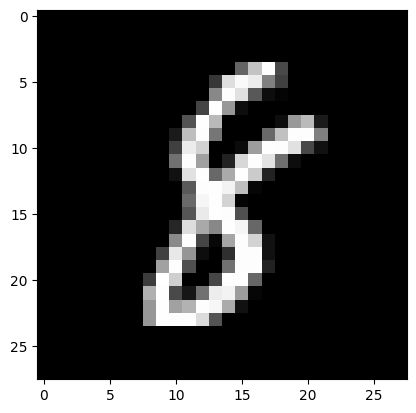

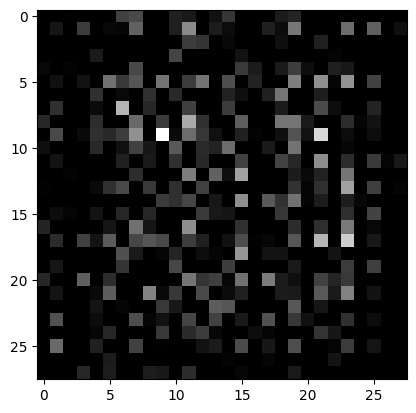

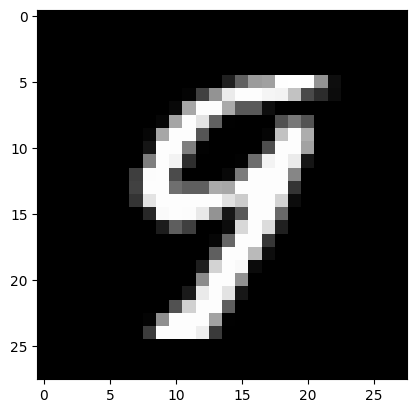

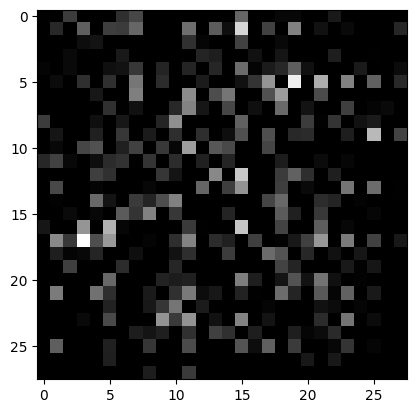

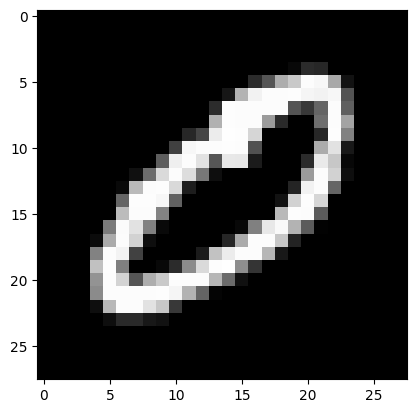

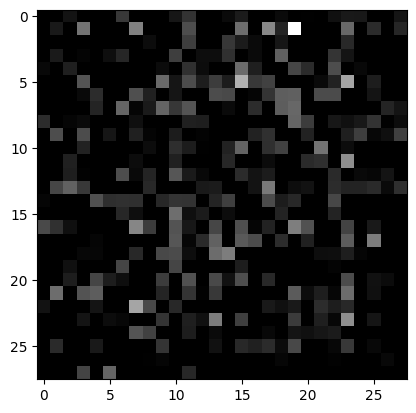

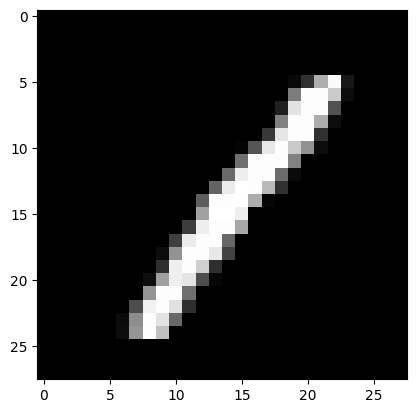

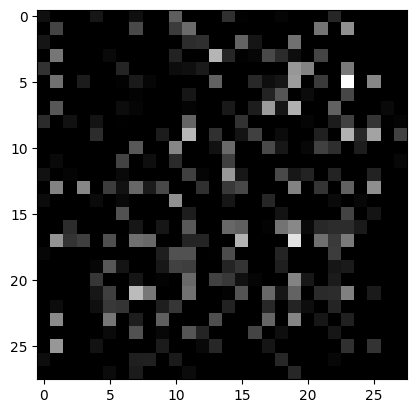

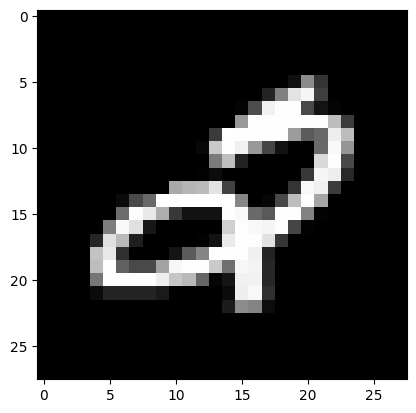

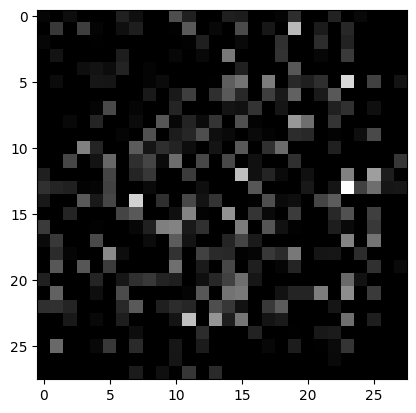

In [22]:
out_img = torch.squeeze(output.cpu().data)
print(out_img.size())

for i in range(5):
  plt.imshow(torch.squeeze(image[i].cpu()).data.numpy(),cmap='gray')
  plt.show()
  plt.imshow(out_img[i].numpy(),cmap='gray')
  plt.show()

#### 훈련

In [23]:
for i in range(num_epoch):
  for j,[image, label] in enumerate(train_loader):
    optimizer.zero_grad()
    image = image.to(device)
    z = encoder(image)
    output = decoder(z)
    loss = loss_func(output, image)
    loss.backward()
    optimizer.step()
  print("loss is", loss.cpu().item())

loss is 0.005154060665518045
loss is 0.003416524501517415
loss is 0.0024866957683116198
loss is 0.0021291091106832027
loss is 0.0016906667733564973
loss is 0.0016234967624768615
loss is 0.001587530947290361
loss is 0.0012379250256344676
loss is 0.0010424238862469792
loss is 0.0010086314287036657


#### 훈련 후 결과 출력

torch.Size([100, 28, 28])


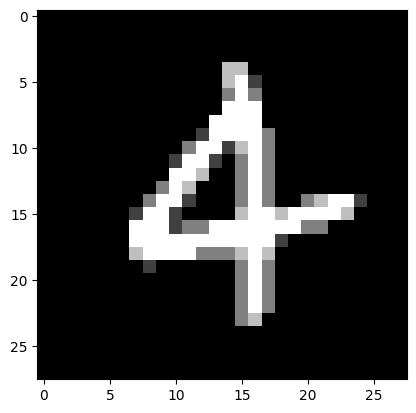

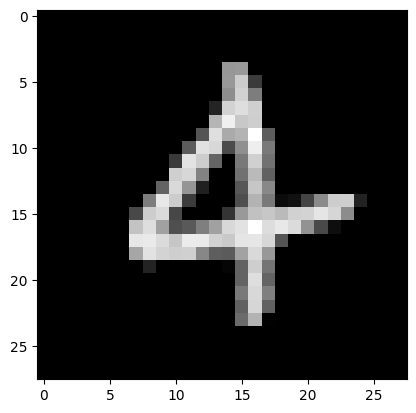

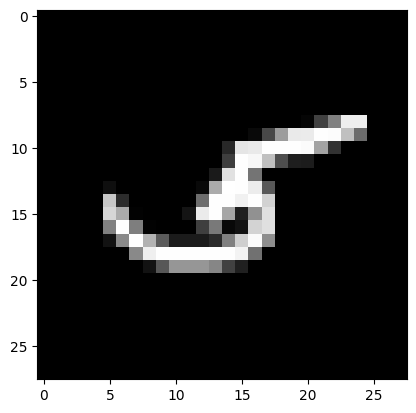

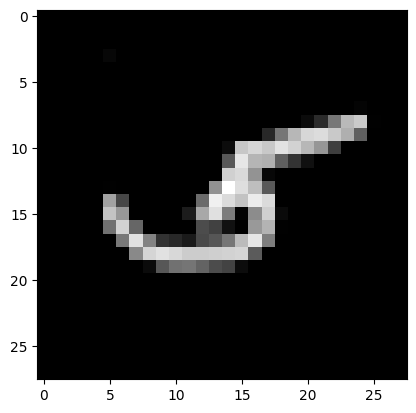

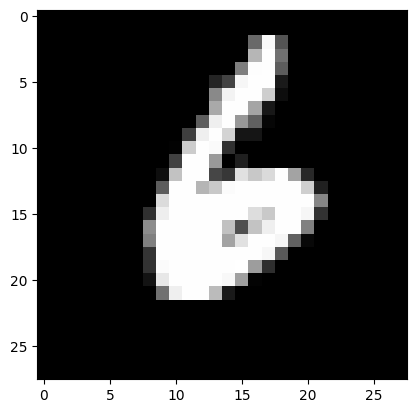

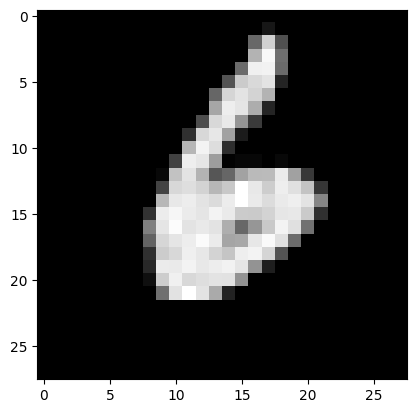

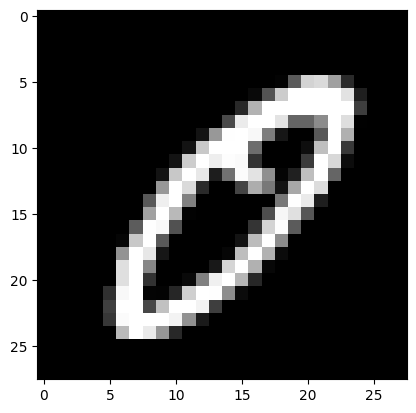

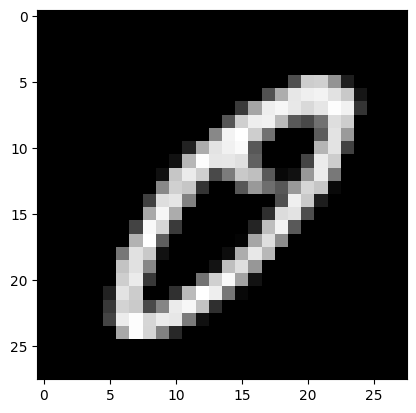

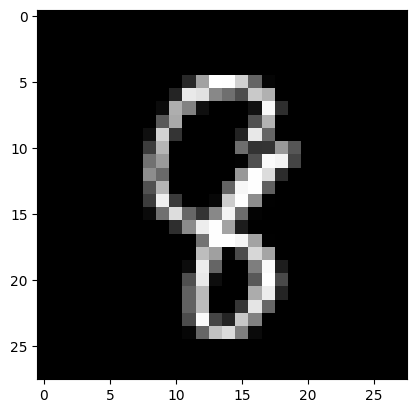

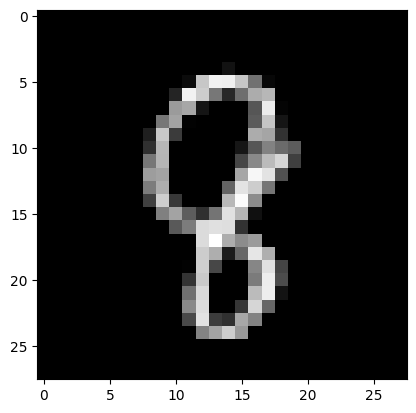

In [24]:
out_img = torch.squeeze(output.cpu().data)
print(out_img.size())

for i in range(5):
  plt.imshow(torch.squeeze(image[i].cpu()).data.numpy(),cmap='gray')
  plt.show()
  plt.imshow(out_img[i].numpy(),cmap='gray')
  plt.show()